<a href="https://colab.research.google.com/github/lamaT5/T5./blob/main/Text_Classification_Practice_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Important Notice! 🚨

While this dataset might seem relatively clean, be prepared! In the actual exam, you may encounter a more challenging dataset containing URLs, emojis, Tashkeel, last Harakah, and other elements that will require proper handling.

Don’t rely on this clean dataset alone! It’s highly recommended that you practice using a different, more complex dataset. Handling these types of noise effectively will not only help you excel in the exam but also prepare you for real-world projects involving Arabic text data.

Here are a few things you might need to clean in other datasets:
- URLs
- Emojis
- Arabic diacritics (Tashkeel) and last Harakah

**Take Your Time**: The more you practice with noisy data, the better equipped you'll be to tackle these challenges confidently, both in the exam and in future projects! 🚀


# Install and Import Needed Libraries

You can use `pyarabic` or any other library to pre-process and clean the Arabic text.

In [1]:
!pip install pyarabic -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 5.9 MB/s eta 0:00:00


In [2]:
!pip install pyarabic emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 14.8 MB/s eta 0:00:00


In [3]:
import re
import emoji
from pyarabic.araby import strip_tashkeel, strip_harakat # تشيل الحركات من النص

# Download the Dataset

In [4]:
!kaggle datasets download -d abedkhooli/arabic-100k-reviews

Dataset URL: https://www.kaggle.com/datasets/abedkhooli/arabic-100k-reviews
License(s): copyright-authors
100% 17.0M/17.0M [00:01<00:00, 27.7MB/s]
100% 17.0M/17.0M [00:01<00:00, 17.5MB/s]


In [5]:
!unzip arabic-100k-reviews.zip

Archive:  arabic-100k-reviews.zip
  inflating: ar_reviews_100k.tsv     


# Data Exploration

Before diving into preprocessing and model building, it’s important to first explore the dataset to understand its structure, distribution, and key characteristics. This step will help you gain insights into the data and guide your decisions in subsequent steps. Here’s what to consider:

1. **Inspect the Data**:
   Start by looking at the first few rows of the dataset to get a sense of its structure. Check the columns, data types, and a few sample entries. This helps to ensure that the data is loaded correctly and gives you an initial overview of the content.

2. **Check for Missing Values**:
   Identify if there are any missing values in the dataset. Missing data can cause issues during model training, so it’s important to handle them early on. You can choose to remove rows with missing values or fill them with appropriate replacements (imputation).

3. **Distribution of Labels**:
   Examine the distribution of the target labels (classes). This step is crucial in classification tasks to determine if the dataset is balanced or imbalanced. A balanced dataset has a roughly equal number of samples for each class, while an imbalanced dataset has a significantly higher number of samples for one class compared to others. For imbalanced datasets, you may need to apply techniques like class weighting or data augmentation.

4. **Text Data Characteristics**:
   Analyze the length of the text data. It is useful to calculate the number of words or characters in each text sample to understand how long the texts are. This will help you set a suitable `max_length` for tokenization and padding later. You can plot a histogram of text lengths to visualize the distribution.

5. **Common Words and Vocabulary**:
   Explore the most frequent words in the text data. This will give you a sense of which words dominate the dataset and could be helpful in later steps, such as stopword removal or adjusting tokenizer settings.

In [9]:
import pandas as pd
df = pd.read_csv('/content/ar_reviews_100k.tsv',delimiter='\t')
df.head()

,label,text
0,Positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1,Positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,Positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3,Positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,Positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...


In [10]:
print(df.iloc[0])

label                                             Positive
text     ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
Name: 0, dtype: object


In [11]:
pd.set_option('display.max_colwidth', 1000)# لعرض نصوص اطول

In [12]:
#2 Check for Missing Values
df.isnull().sum()

,0
label,0
text,0


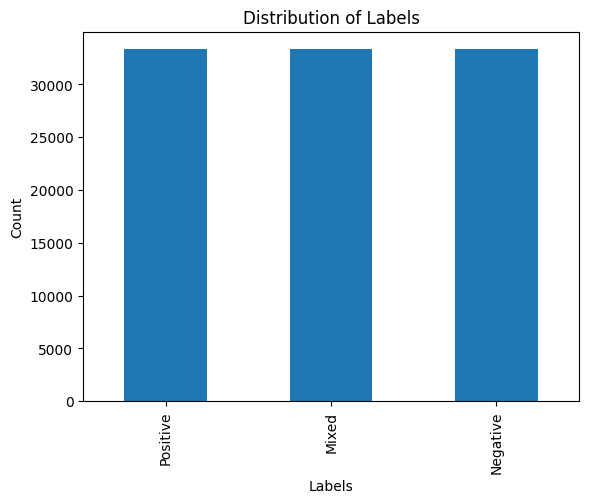

In [13]:
#3 Distribution of Labels:
import matplotlib.pyplot as plt

# Assuming 'label' is the column with target labels
label_counts = df['label'].value_counts()

# Plot the distribution
label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

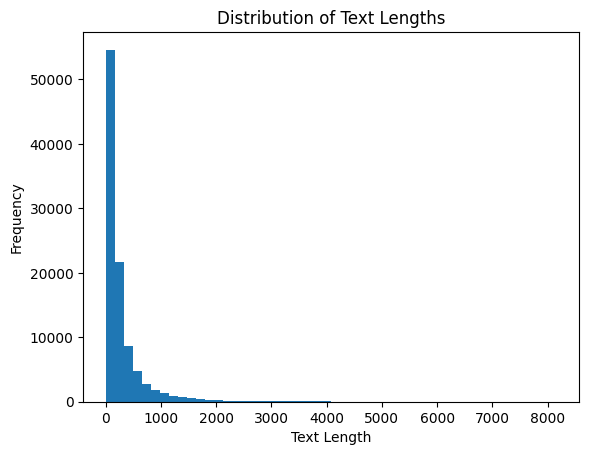

In [14]:
# 4 Text Data Characteristics
df['text_length'] = df['text'].apply(len)

# Plot a histogram of text lengths
df['text_length'].plot(kind='hist', bins=50)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Data Cleaning and Preprocessing

In this section, we will focus on cleaning and filtering the dataset, preparing it for the text classification task. We will implement the following steps:

1. **Remove missing values**:
   First, we eliminate any rows with missing values to ensure the dataset is complete and consistent.

2. **Filter by text length**:
   To maintain a uniform dataset, we will filter the text samples by a specified word count range. This ensures that the texts are neither too short to lack context nor too long to introduce unnecessary complexity.

3. **Exclude 'Mixed' labels**:
   If the dataset contains any 'Mixed' labels, indicating ambiguous or unclear classification, we will remove these entries for better model accuracy.

4. **Arabic stopwords loading**:
   We load a list of Arabic stopwords to filter out commonly used but contextually insignificant words. This is an important step for improving the performance of the model, as stopwords do not contribute valuable information.

5. **Text cleaning**:
   We apply a series of text cleaning steps to standardize and simplify the text data. This involves:
   
   - **Removing links (URLs)**: Any URLs present in the text are removed as they are not meaningful for classification purposes.
   - **Removing special characters and punctuation**: This step removes any non-alphabetical characters, ensuring the text only contains meaningful words.
   - **Removing Arabic diacritics (Tashkeel) and elongated letters (Tatweel)**: Diacritical marks and elongated letters are stripped out to standardize the text.
   - **Removing Arabic stopwords**: Words that are part of the stopwords list are removed, as they do not add value to the classification task.
   - **Stemming**: Each word is reduced to its root form using an Arabic stemmer (ISRIStemmer) to simplify the vocabulary.
   - **Normalizing Hamza**: Any variation of the Hamza character is normalized for consistency.

6. **Final cleanup**:
   Apply the cleanup function to the feature column.

By following these steps, the text will be cleaned, filtered, and ready for tokenization!

In [15]:
#1 Remove missing values
df = df.dropna()

In [16]:
# 2 Filter by text length
# دالة لحساب الكلمات
def word_count(text):
  return len(text.split())


# Filter texts by word count range (e.g., between 5 and 100 words)
df = df[df['text'].apply(word_count).between(5, 100)]

In [17]:
# 3 Remove rows with 'Mixed' labels حذف العلامات من النص

df = df[df['label'] != 'Mixed']

In [18]:
# 4 Arabic stopwords loading:
# احمل الكلمات العربيه الشائعة واصفي منها الكلمات الي مالها اهميه لتحسين اداء المودل
from nltk.corpus import stopwords
import nltk

# Download Arabic stopwords
nltk.download('stopwords')
arabic_stopwords = set(stopwords.words('arabic'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:

# 5 Text cleaning:
import re
from pyarabic.araby import strip_tashkeel, strip_tatweel
from nltk.stem.isri import ISRIStemmer

stemmer = ISRIStemmer()

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove Arabic diacritics (Tashkeel) and elongated letters (Tatweel)
    text = strip_tashkeel(text)
    text = strip_tatweel(text)
    # Remove Arabic stopwords
    text = ' '.join([word for word in text.split() if word not in arabic_stopwords])
    # Stemming
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    # Normalize Hamza
    text = re.sub(r'[إأآا]', 'ا', text)
    return text

# Apply the cleanup function to the text column
df['cleaned_text'] = df['text'].apply(clean_text)

In [20]:
# 6 Final cleanup: Apply the cleanup function to the feature column.

print(df.head())

      label  \
0  Positive   
1  Positive   
2  Positive   
4  Positive   
5  Positive   

                                                                                                                                                                                                                                                                                text  \
0                                                                                                                                                                                                                          ممتاز نوعا ما . النظافة والموقع والتجهيز والشاطيء. المطعم   
1  أحد أسباب نجاح الإمارات أن كل شخص في هذه الدولة يعشق ترابها. نحن نحب الإمارات. ومضات من فكر. نصائح لدولة تطمح بالصفوف الأولى و قائد لا يقبل إلا براحة شعبه وتوفر كل سب العيش الكريم. حكم و مواقف ونصائح لكل فرد فينا ليس بمجرد كتاب سياسي كما كنت اعتقد. يستحق القراءة مرات كثيرة   
2                    هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى ه

# Tokenization, Padding, and Data Splitting

In this step, we will prepare the text data for input into a machine learning model by converting the text into numerical sequences, padding them to a uniform length, and splitting the dataset into training and testing sets. Here's an overview of the steps involved:

1. **Tokenization**:
   We use a tokenizer to convert the cleaned text into numerical sequences. Each word in the text is assigned a unique integer ID based on the frequency of its occurrence in the dataset. This allows the text to be represented numerically, which is necessary for model training.

2. **Text to sequences**:
   After fitting the tokenizer on the cleaned text, we transform each text into a sequence of numbers, where each number corresponds to a token (word) in the text. These sequences represent the entire dataset in numerical form.

3. **Padding the sequences**:
   Since different texts may vary in length, we pad the sequences to ensure they all have the same length. Padding adds zeroes at the end (or beginning) of each sequence until they reach the defined maximum length. This is important for creating uniform input data for the model.

4. **Label encoding**:
   The labels (target values) also need to be converted into numerical form. We use a label encoder to transform the categorical labels into numerical representations. This step is essential because machine learning models work with numerical data.

5. **Train-test split**:
   The dataset is divided into training and testing sets. We allocate 80% of the data for training the model and reserve 20% for testing its performance. This split ensures that we have a portion of the data to evaluate how well the model generalizes to unseen data.
   
   - The **training data** consists of the padded sequences used to train the model.
   - The **training labels** are the encoded labels corresponding to the training data.
   - The **testing data** is used to assess the model’s performance after training.
   - The **testing labels** are the encoded labels corresponding to the testing data.

6. **Data shape confirmation**:
   After splitting the data, we print the shape (dimensions) of both the training and testing sets to confirm that the data is properly divided and formatted.

By the end of this step, the text data will be transformed into padded numerical sequences, the labels will be encoded, and the data will be split into training and testing sets for model development and evaluation.

In [21]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [22]:
#1
# Load the cleaned dataset
df = pd.read_csv('/content/ar_reviews_100k.tsv', sep='\t')

# Initialize the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])


In [23]:
# 2 Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['text'])

In [24]:
# 3 Padding the sequences
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [25]:
# 4 Label encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['label'])

In [26]:
# 5 Train-test split:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42,shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=True)

In [27]:
# 6 Data shape confirmation:
print('Training data shape:',X_train.shape)
print('Testing data shape:', X_test.shape)
print('Training labels shape:', y_train.shape)
print('Testing labels shape:', y_test.shape)

Training data shape: (69999, 1616)
Testing data shape: (15000, 1616)
Training labels shape: (69999,)
Testing labels shape: (15000,)


# Building the RNN Model

In this step, you will design and build a Recurrent Neural Network (RNN) model to classify text data. Below is a breakdown of the key components you'll implement, but it's up to you to decide how to configure them based on your understanding and experimentation:

1. **Model Type**:
   You will use a Sequential model, which allows you to stack layers in a linear sequence. Feel free to explore different model types if necessary.

2. **Input Layer**:
   Define the shape of the input data. Consider the dimensions of your padded sequences and set the input shape accordingly.

3. **Embedding Layer**:
   The embedding layer will convert input tokens (integers) into dense vector representations. You will need to determine the size of the input dimension (based on your vocabulary) and the output dimension (embedding size). The embedding size is a hyperparameter, so feel free to experiment with different values.

4. **Bidirectional Simple RNN Layers**:
   You can add one or more recurrent layers. Consider using Bidirectional layers to capture contextual information from both directions (forward and backward). You have the option to specify the number of units in each layer. Additionally, you can decide whether to return sequences from the layers and how many layers to stack.

5. **Dense Layers**:
   Add one or more fully connected (Dense) layers to process the output from the RNN layers. You will need to choose the number of units for these layers and decide on an activation function. ReLU is a common choice, but feel free to explore other options depending on your task.

6. **Output Layer**:
   The output layer should match the type of classification task you're working on. For a binary classification task, consider using a single unit with an appropriate activation function (e.g., sigmoid). If you're working on a multi-class classification, a different setup may be required.

7. **Model Summary**:
   After defining your model architecture, print a summary to review the number of layers, types of layers, and total parameters.

8. **Model Compilation**:
   Finally, compile the model by selecting an optimizer, a loss function, and metrics. Common choices include Adam for the optimizer and binary cross-entropy for the loss function in binary classification, but this is entirely up to you. You can experiment with different optimizers and loss functions to see what works best for your specific problem.

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Bidirectional

# Define the vocabulary size and embedding size
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
embedding_size = 100  # You can experiment with different values

# Build the RNN model
model = Sequential()

# Add the Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_length))

# Add a Bidirectional Simple RNN layer
model.add(Bidirectional(SimpleRNN(units=64, return_sequences=True)))
model.add(Bidirectional(SimpleRNN(units=64)))

# Add Dense layers
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))

# Add the output layer for binary classification
model.add(Dense(units=1, activation='sigmoid'))

# Print the model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Defining Batch Size, Creating Datasets, and Training the Model

In this step, you will define the batch size, create TensorFlow Datasets for both training and testing, and train the model. The key elements to consider are outlined below, and it is up to you to choose the specific configurations based on your preferences and experimentation:

1. **Batch Size**:
   Select a batch size for training and testing. The batch size determines how many samples will be processed together in one forward and backward pass during training. Smaller batch sizes may allow for more granular updates, while larger batch sizes might lead to faster but less frequent updates. You can experiment with different values.

2. **Creating Datasets**:
   Use TensorFlow’s `Dataset.from_tensor_slices()` to create datasets from the training and testing data. This step converts the feature data and labels into pairs of tensors, which can be efficiently fed into the model during training and testing.

3. **Batching the Datasets**:
   Batch the datasets by grouping the data into batches of the specified size. This is important for ensuring that the model processes the data in manageable chunks during training. You can choose the batch size that works best for your hardware and data.

4. **Training the Model**:
   Train the model by fitting it on the training dataset for a specified number of epochs. You will also need to provide the validation data (the testing dataset in this case) to monitor the model’s performance on unseen data during training. The number of epochs is another hyperparameter you can adjust, with higher values potentially leading to better performance but risking overfitting.

5. **Tracking Training History**:
   During training, the model’s performance metrics (such as loss and accuracy) will be tracked over the epochs, and the results will be stored in the `history` object. You can use this to analyze and visualize how the model’s performance evolves over time.

In [29]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size)

In [30]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [31]:
history = model.fit(train_dataset, epochs=4, validation_data=val_dataset, callbacks=early_stopping,steps_per_epoch=len(X_train) // batch_size-5)

Epoch 1/4
 514/2182 ━━━━━━━━━━━━━━━━━━━━ 16:46 604ms/step - accuracy: 0.3658 - loss: -90.6424

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(history.history).plot()

# Model Evaluation

Once the model is trained, the next step is to evaluate its performance on the testing dataset. This will give you a sense of how well the model generalizes to unseen data. Here’s an overview of what you need to consider for this step:

1. **Evaluate the Model**:
   You will use the `evaluate()` method to assess the model’s performance on the test dataset. This method calculates the loss and other metrics (e.g., accuracy) that you specified during model compilation. It provides a final measure of how well the model performs on data it hasn’t seen during training.

2. **Testing Dataset**:
   Ensure that the testing dataset is properly prepared and batched, just like the training dataset. The evaluation process will loop through the batches and compute the overall performance across the entire test set.

3. **Metrics**:
   The metrics used during evaluation are the same as those defined in the model’s compilation step. Common metrics include accuracy for classification tasks, but feel free to define and track any other metrics of interest.

4. **Loss Curve**:
   A loss curve plots the loss values for both the training and validation datasets over the epochs. This visualization helps to monitor the model’s performance during training. A decreasing training loss usually indicates that the model is learning, while the validation loss shows how well the model generalizes to unseen data.

In [ ]:
model.evaluate(test_dataset)

In [ ]:
pred = model.predict(test_dataset)

# Model Inference

In this step, you will use the trained model to make predictions on new, unseen data (inference). Here’s an outline of the key points:

1. **Prepare New Data**:
   Before making predictions, ensure that the new data is preprocessed in the same way as the training data. This includes tokenization, padding, and any other transformations you applied during the data preprocessing step. The data can be single text to see the result of the prediction.

2. **Model Prediction**:
   Use the `predict()` method to feed new samples into the trained model and obtain predictions. The model will output probabilities or predicted class labels based on the type of classification task (binary or multi-class).

3. **Interpreting Predictions**:
   The model will return probabilities for each class. For binary classification, the output will typically be a probability value between 0 and 1.